Import Libraries

In [1]:
import pandas as pd
import numpy as np
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

Load Puebla Mexico Earthquake Data

In [2]:
def load_data(train_path, dev_path, test_path):
    train_df = pd.read_csv(train_path, sep="\t")
    dev_df = pd.read_csv(dev_path, sep="\t")
    test_df = pd.read_csv(test_path, sep="\t")

    # Combine train data and dev data for better training
    train_df = pd.concat([train_df, dev_df], ignore_index=True)
    return train_df, test_df

train_path = "/content/puebla_mexico_earthquake_2017_train.tsv"
dev_path = "/content/puebla_mexico_earthquake_2017_dev.tsv"
test_path = "/content/puebla_mexico_earthquake_2017_test.tsv"

train_df, test_df = load_data(train_path, dev_path, test_path)

In [3]:
train_df

,tweet_id,tweet_text,class_label
0,910609673556037632,"Pray for the victims, families,survivors of ea...",sympathy_and_support
1,910612779148632064,RT @CalumWorthy: The tragedy in Mexico is brea...,sympathy_and_support
2,912078801852665863,Bethenny Frankel helps with earthquake relief ...,rescue_volunteering_or_donation_effort
3,911814577658241025,Frida the rescue dog emerges as hero of Mexica...,rescue_volunteering_or_donation_effort
4,910547294923231232,RT @nowthisnews: People are rescuing survivors...,rescue_volunteering_or_donation_effort
...,...,...,...
1610,912430421543198720,RT @diegoluna_: Please join!! Lets help those ...,requests_or_urgent_needs
1611,910584158602199040,RT @mashable: Heres how to help Mexico City af...,rescue_volunteering_or_donation_effort
1612,910766780079050752,RT @hyungwonope: [news articles] MONSTA X winn...,sympathy_and_support
1613,910780771429945344,Race To Save Mexico Earthquake Survivors Conti...,rescue_volunteering_or_donation_effort


In [4]:
test_df

,tweet_id,tweet_text,class_label
0,911718749115478021,RT @RealZapoteca: A #Dog Named Frida Is on a M...,rescue_volunteering_or_donation_effort
1,910716633567592448,What horrible news about the earthquake in Mex...,sympathy_and_support
2,911981384935329793,RT @OfficialJoelF: Frida the rescue dog has sa...,rescue_volunteering_or_donation_effort
3,911832338891288576,Just In 6.2 Magnitude Strong Earthquake Strik...,other_relevant_information
4,912127610695516161,RT @grillo1138: Look @NintendoAmerica The guys...,sympathy_and_support
...,...,...,...
395,911622251166015489,Another Earthquake in Mexico devastating event...,not_humanitarian
396,911804971204710400,A 6.2 magnitude earthquake is the latest to hi...,other_relevant_information
397,910525883579998208,RT @emilytgreen: Removing the jungle gym from ...,injured_or_dead_people
398,910678250480742400,RT @theonlyleaderBB: Buildings can be seen mov...,infrastructure_and_utility_damage


ALL DATA

In [5]:
tweet_data = pd.concat([train_df, test_df], ignore_index=True)

In [6]:
tweet_data['class_label'].value_counts()

,count
class_label,
rescue_volunteering_or_donation_effort,984
sympathy_and_support,367
injured_or_dead_people,254
infrastructure_and_utility_damage,167
other_relevant_information,109
requests_or_urgent_needs,61
not_humanitarian,38
caution_and_advice,35


Data Preprocessing

In [7]:
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    text = re.sub(r"\@\w+|\#", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"\d+", "", text)
    return text.strip()

train_df["clean_text"] = train_df["tweet_text"].apply(clean_text)
test_df["clean_text"] = test_df["tweet_text"].apply(clean_text)

In [8]:
vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
X_train = vectorizer.fit_transform(train_df["clean_text"])
X_test = vectorizer.transform(test_df["clean_text"])

In [9]:
label_mapping = {label: idx for idx, label in enumerate(train_df["class_label"].unique())}
y_train = train_df["class_label"].map(label_mapping)
y_test = test_df["class_label"].map(label_mapping)

Define confusion matrix

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, model_name, class_labels):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

    plt.xlabel("Predicted Labels", fontsize=10)
    plt.ylabel("Actual Labels", fontsize=10)
    plt.title(f"Confusion Matrix - {model_name}", fontsize=10)

    plt.xticks(rotation=90)
    plt.yticks(rotation=0)

    plt.show()

class_labels = list(label_mapping.keys())


In [11]:
def evaluate_model(y_true, y_pred, model_name):
    precision = precision_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    accuracy = accuracy_score(y_true, y_pred)
    print(f"\n{model_name} Evaluation:")
    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'F1 Score: {f1}')

    print("\n Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels))

Decision Tree

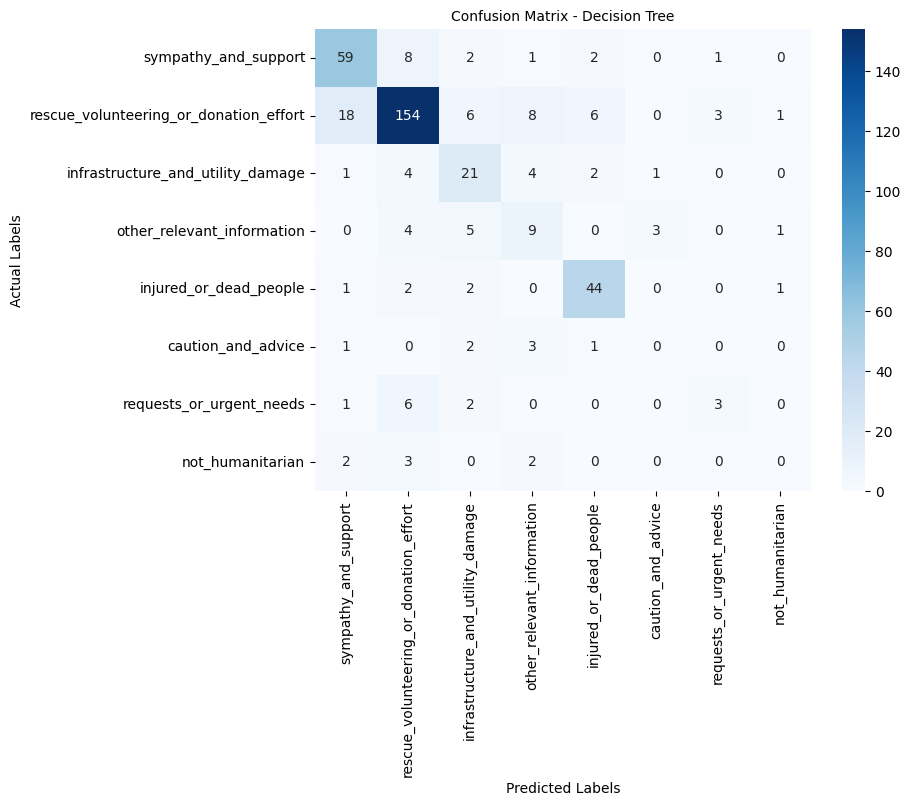


Decision Tree Evaluation:
Accuracy: 0.725
Precision: 0.7211379692011931
F1 Score: 0.7202685982118814

 Classification Report:
                                        precision    recall  f1-score   support

                  sympathy_and_support       0.71      0.81      0.76        73
rescue_volunteering_or_donation_effort       0.85      0.79      0.82       196
     infrastructure_and_utility_damage       0.53      0.64      0.58        33
            other_relevant_information       0.33      0.41      0.37        22
                injured_or_dead_people       0.80      0.88      0.84        50
                    caution_and_advice       0.00      0.00      0.00         7
              requests_or_urgent_needs       0.43      0.25      0.32        12
                      not_humanitarian       0.00      0.00      0.00         7

                              accuracy                           0.72       400
                             macro avg       0.46      0.47      0.46  

In [12]:
from sklearn.metrics import accuracy_score, classification_report, precision_score, f1_score, recall_score

dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
dt_preds = dt_model.predict(X_test)

plot_confusion_matrix(y_test, dt_preds, "Decision Tree", class_labels)
evaluate_model(y_test, dt_preds,"Decision Tree")


Random Forest

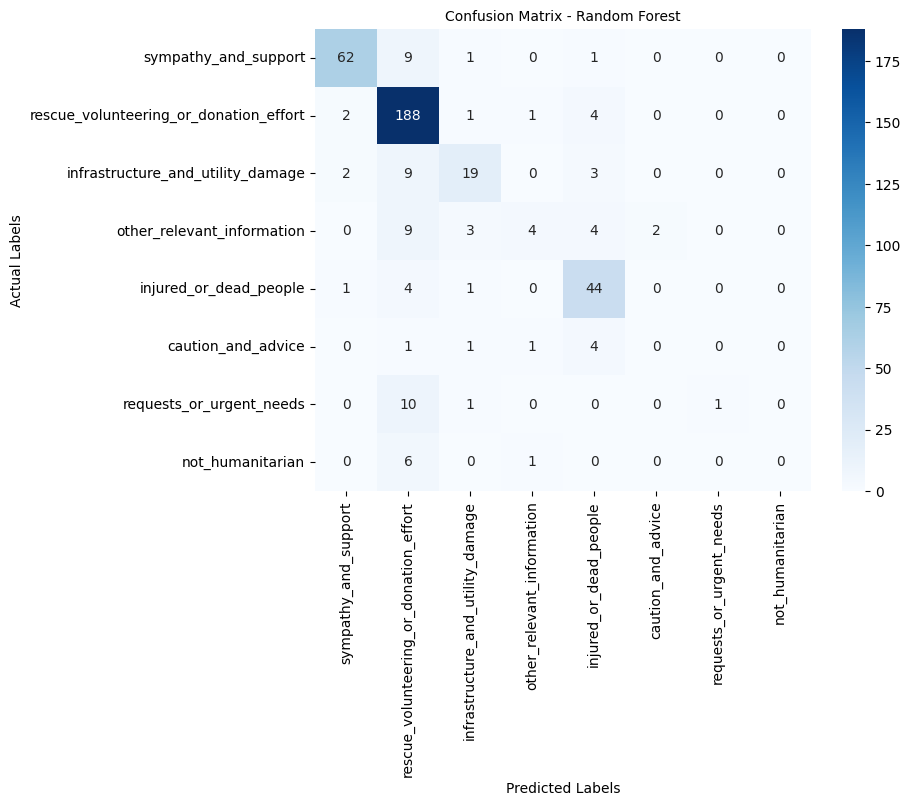


Random Forest Evaluation:
Accuracy: 0.795
Precision: 0.7703703737165665
F1 Score: 0.7601621370328268

 Classification Report:
                                        precision    recall  f1-score   support

                  sympathy_and_support       0.93      0.85      0.89        73
rescue_volunteering_or_donation_effort       0.80      0.96      0.87       196
     infrastructure_and_utility_damage       0.70      0.58      0.63        33
            other_relevant_information       0.57      0.18      0.28        22
                injured_or_dead_people       0.73      0.88      0.80        50
                    caution_and_advice       0.00      0.00      0.00         7
              requests_or_urgent_needs       1.00      0.08      0.15        12
                      not_humanitarian       0.00      0.00      0.00         7

                              accuracy                           0.80       400
                             macro avg       0.59      0.44      0.45  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [13]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

plot_confusion_matrix(y_test, rf_preds, "Random Forest", class_labels)
evaluate_model(y_test, rf_preds,"Random Forest")

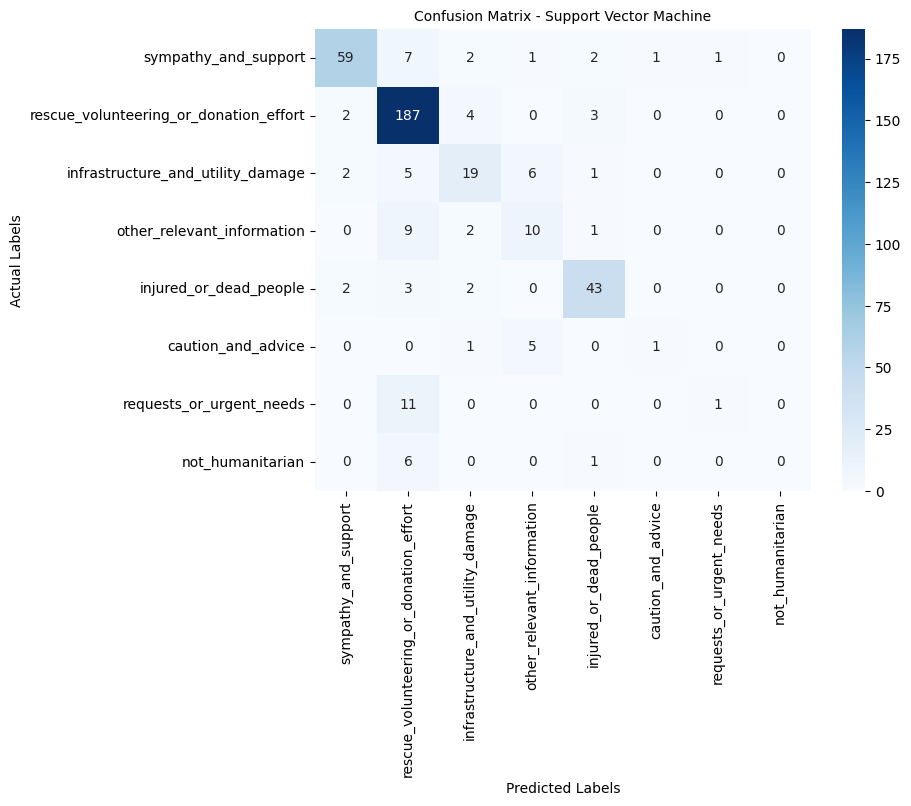


Support Vector Machine Evaluation:
Accuracy: 0.8
Precision: 0.7739319679288719
F1 Score: 0.777639857270621

 Classification Report:
                                        precision    recall  f1-score   support

                  sympathy_and_support       0.91      0.81      0.86        73
rescue_volunteering_or_donation_effort       0.82      0.95      0.88       196
     infrastructure_and_utility_damage       0.63      0.58      0.60        33
            other_relevant_information       0.45      0.45      0.45        22
                injured_or_dead_people       0.84      0.86      0.85        50
                    caution_and_advice       0.50      0.14      0.22         7
              requests_or_urgent_needs       0.50      0.08      0.14        12
                      not_humanitarian       0.00      0.00      0.00         7

                              accuracy                           0.80       400
                             macro avg       0.58      0.48      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [14]:
svm_model = SVC(kernel="linear", random_state=42)
svm_model.fit(X_train, y_train)
svm_preds = svm_model.predict(X_test)

plot_confusion_matrix(y_test, svm_preds, "Support Vector Machine", class_labels)
evaluate_model(y_test, svm_preds,"Support Vector Machine")